定义一些基本的函数

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.training.preprocessing.utils.vector_preprocessing import interpolate_points
from nuplan.common.geometry.torch_geometry import vector_set_coordinates_to_local_frame
from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
from nuplan.planning.training.preprocessing.features.trajectory_utils import convert_absolute_to_relative_poses
from nuplan.common.geometry.torch_geometry import global_state_se2_tensor_to_local
from nuplan.planning.training.preprocessing.features.agents import Agents
from nuplan.planning.training.preprocessing.utils.agents_preprocessing import (
	AgentInternalIndex,
	AgentFeatureIndex,
	EgoInternalIndex,
	sampled_past_ego_states_to_tensor,
	sampled_past_timestamps_to_tensor,
	compute_yaw_rate_from_state_tensors,
	filter_agents_tensor,
	pack_agents_tensor,
	pad_agent_states
)

from nuplan.planning.training.preprocessing.feature_builders.vector_builder_utils import (
	MapObjectPolylines,
	LaneSegmentTrafficLightData,
	VectorFeatureLayer, 
 	VectorFeatureLayerMapping,
	get_lane_polylines,
	get_traffic_light_encoding,
 	get_route_lane_polylines_from_roadblock_ids,
	get_map_object_polygons
)

from nuplan.common.maps.maps_datatypes import TrafficLightStatusData
from nuplan.common.actor_state.state_representation import Point2D, StateSE2
from nuplan.common.maps.abstract_map import AbstractMap

from typing import List, Dict, Tuple

def get_filter_parameters(num_scenarios_per_type=20, limit_total_scenarios=None, shuffle=True):
	# nuplan challenge
	scenario_types = [
		'starting_left_turn',
		'starting_right_turn',
		'starting_straight_traffic_light_intersection_traversal',
		'stopping_with_lead',
		'high_lateral_acceleration',
		'high_magnitude_speed',
		'low_magnitude_speed',
		'traversing_pickup_dropoff',
		'waiting_for_pedestrian_to_cross',
		'behind_long_vehicle',
		'stationary_in_traffic',
		'near_multiple_vehicles',
		'changing_lane',
		'following_lane_with_lead',
	]

	scenario_tokens = None              # List of scenario tokens to include
	log_names = None                     # Filter scenarios by log names
	map_names = None                     # Filter scenarios by map names

	num_scenarios_per_type               # Number of scenarios per type
	limit_total_scenarios                # Limit total scenarios (float = fraction, int = num) - this filter can be applied on top of num_scenarios_per_type
	timestamp_threshold_s = None          # Filter scenarios to ensure scenarios have more than `timestamp_threshold_s` seconds between their initial lidar timestamps
	ego_displacement_minimum_m = None    # Whether to remove scenarios where the ego moves less than a certain amount

	expand_scenarios = False           # Whether to expand multi-sample scenarios to multiple single-sample scenarios
	remove_invalid_goals = True         # Whether to remove scenarios where the mission goal is invalid
	shuffle                             # Whether to shuffle the scenarios

	ego_start_speed_threshold = None     # Limit to scenarios where the ego reaches a certain speed from below
	ego_stop_speed_threshold = None      # Limit to scenarios where the ego reaches a certain speed from above
	speed_noise_tolerance = None         # Value at or below which a speed change between two timepoints should be ignored as noise.

	return scenario_types, scenario_tokens, log_names, map_names, num_scenarios_per_type, limit_total_scenarios, timestamp_threshold_s, ego_displacement_minimum_m, \
		   expand_scenarios, remove_invalid_goals, shuffle, ego_start_speed_threshold, ego_stop_speed_threshold, speed_noise_tolerance

def get_scenario_map():
	scenario_map = {
		'accelerating_at_crosswalk': [15.0, -3.0],
		'accelerating_at_stop_sign': [15.0, -3.0],
		'accelerating_at_stop_sign_no_crosswalk': [15.0, -3.0],
		'accelerating_at_traffic_light': [15.0, -3.0],
		'accelerating_at_traffic_light_with_lead': [15.0, -3.0],
		'accelerating_at_traffic_light_without_lead': [15.0, -3.0],
		'behind_bike': [15.0, -3.0],
		'behind_long_vehicle': [15.0, -3.0],
		'behind_pedestrian_on_driveable': [15.0, -3.0],
		'behind_pedestrian_on_pickup_dropoff': [15.0, -3.0],
		'changing_lane': [15.0, -3.0],
		'changing_lane_to_left': [15.0, -3.0],
		'changing_lane_to_right': [15.0, -3.0],
		'changing_lane_with_lead': [15.0, -3.0],
		'changing_lane_with_trail': [15.0, -3.0],
		'crossed_by_bike': [15.0, -3.0],
		'crossed_by_vehicle': [15.0, -3.0],
		'following_lane_with_lead': [15.0, -3.0],
		'following_lane_with_slow_lead': [15.0, -3.0],
		'following_lane_without_lead': [15.0, -3.0],
		'high_lateral_acceleration': [15.0, -3.0],
		'high_magnitude_jerk': [15.0, -3.0],
		'high_magnitude_speed': [15.0, -3.0],
		'low_magnitude_speed': [15.0, -3.0],
		'medium_magnitude_speed': [15.0, -3.0],
		'near_barrier_on_driveable': [15.0, -3.0],
		'near_construction_zone_sign': [15.0, -3.0],
		'near_high_speed_vehicle': [15.0, -3.0],
		'near_long_vehicle': [15.0, -3.0],
		'near_multiple_bikes': [15.0, -3.0],
		'near_multiple_pedestrians': [15.0, -3.0],
		'near_multiple_vehicles': [15.0, -3.0],
		'near_pedestrian_at_pickup_dropoff': [15.0, -3.0],
		'near_pedestrian_on_crosswalk': [15.0, -3.0],
		'near_pedestrian_on_crosswalk_with_ego': [15.0, -3.0],
		'near_trafficcone_on_driveable': [15.0, -3.0],
		'on_all_way_stop_intersection': [15.0, -3.0],
		'on_carpark': [15.0, -3.0],
		'on_intersection': [15.0, -3.0],
		'on_pickup_dropoff': [15.0, -3.0],
		'on_stopline_crosswalk': [15.0, -3.0],
		'on_stopline_stop_sign': [15.0, -3.0],
		'on_stopline_traffic_light': [15.0, -3.0],
		'on_traffic_light_intersection': [15.0, -3.0],
		'starting_high_speed_turn': [15.0, -3.0],
		'starting_left_turn': [15.0, -3.0],
		'starting_low_speed_turn': [15.0, -3.0],
		'starting_protected_cross_turn': [15.0, -3.0],
		'starting_protected_noncross_turn': [15.0, -3.0],
		'starting_right_turn': [15.0, -3.0],
		'starting_straight_stop_sign_intersection_traversal': [15.0, -3.0],
		'starting_straight_traffic_light_intersection_traversal': [15.0, -3.0],
		'starting_u_turn': [15.0, -3.0],
		'starting_unprotected_cross_turn': [15.0, -3.0],
		'starting_unprotected_noncross_turn': [15.0, -3.0],
		'stationary': [15.0, -3.0],
		'stationary_at_crosswalk': [15.0, -3.0],
		'stationary_at_traffic_light_with_lead': [15.0, -3.0],
		'stationary_at_traffic_light_without_lead': [15.0, -3.0],
		'stationary_in_traffic': [15.0, -3.0],
		'stopping_at_crosswalk': [15.0, -3.0],
		'stopping_at_stop_sign_no_crosswalk': [15.0, -3.0],
		'stopping_at_stop_sign_with_lead': [15.0, -3.0],
		'stopping_at_stop_sign_without_lead': [15.0, -3.0],
		'stopping_at_traffic_light_with_lead': [15.0, -3.0],
		'stopping_at_traffic_light_without_lead': [15.0, -3.0],
		'stopping_with_lead': [15.0, -3.0],
		'traversing_crosswalk': [15.0, -3.0],
		'traversing_intersection': [15.0, -3.0],
		'traversing_narrow_lane': [15.0, -3.0],
		'traversing_pickup_dropoff': [15.0, -3.0],
		'traversing_traffic_light_intersection': [15.0, -3.0],
		'waiting_for_pedestrian_to_cross': [15.0, -3.0]
	}

	return scenario_map

def _extract_agent_tensor(tracked_objects, track_token_ids, object_types):
	"""
	Extracts the relevant data from the agents present in a past detection into a tensor.
	Only objects of specified type will be transformed. Others will be ignored.
	The output is a tensor as described in AgentInternalIndex
	:param tracked_objects: The tracked objects to turn into a tensor.
	:track_token_ids: A dictionary used to assign track tokens to integer IDs.
	:object_type: TrackedObjectType to filter agents by.
	:return: The generated tensor and the updated track_token_ids dict.
	"""
	agents = tracked_objects.get_tracked_objects_of_types(object_types)
	agent_types = []
	output = torch.zeros((len(agents), AgentInternalIndex.dim()), dtype=torch.float32)
	max_agent_id = len(track_token_ids)

	for idx, agent in enumerate(agents):
		if agent.track_token not in track_token_ids:
			track_token_ids[agent.track_token] = max_agent_id
			max_agent_id += 1
		track_token_int = track_token_ids[agent.track_token]

		output[idx, AgentInternalIndex.track_token()] = float(track_token_int)
		output[idx, AgentInternalIndex.vx()] = agent.velocity.x
		output[idx, AgentInternalIndex.vy()] = agent.velocity.y
		output[idx, AgentInternalIndex.heading()] = agent.center.heading
		output[idx, AgentInternalIndex.width()] = agent.box.width
		output[idx, AgentInternalIndex.length()] = agent.box.length
		output[idx, AgentInternalIndex.x()] = agent.center.x
		output[idx, AgentInternalIndex.y()] = agent.center.y
		agent_types.append(agent.tracked_object_type)

	return output, track_token_ids, agent_types

def sampled_tracked_objects_to_tensor_list(past_tracked_objects):
	"""
	Tensorizes the agents features from the provided past detections.
	For N past detections, output is a list of length N, with each tensor as described in `_extract_agent_tensor()`.
	:param past_tracked_objects: The tracked objects to tensorize.
	:return: The tensorized objects.
	"""
	object_types = [TrackedObjectType.VEHICLE, TrackedObjectType.PEDESTRIAN, TrackedObjectType.BICYCLE]
	output = []
	output_types = []
	track_token_ids = {}

	for i in range(len(past_tracked_objects)):
		tensorized, track_token_ids, agent_types = _extract_agent_tensor(past_tracked_objects[i], track_token_ids, object_types)
		output.append(tensorized)
		output_types.append(agent_types)

	return output, output_types

def global_velocity_to_local(velocity, anchor_heading):
	velocity_x = velocity[:, 0] * torch.cos(anchor_heading) + velocity[:, 1] * torch.sin(anchor_heading)
	velocity_y = velocity[:, 1] * torch.cos(anchor_heading) - velocity[:, 0] * torch.sin(anchor_heading)

	return torch.stack([velocity_x, velocity_y], dim=-1)

def convert_absolute_quantities_to_relative(agent_state, ego_state, agent_type='ego'):
	"""
	Converts the agent' poses and relative velocities from absolute to ego-relative coordinates.
	:param agent_state: The agent states to convert, in the AgentInternalIndex schema.
	:param ego_state: The ego state to convert, in the EgoInternalIndex schema.
	:return: The converted states, in AgentInternalIndex schema.
	"""
	ego_pose = torch.tensor(
		[
			float(ego_state[EgoInternalIndex.x()].item()),
			float(ego_state[EgoInternalIndex.y()].item()),
			float(ego_state[EgoInternalIndex.heading()].item()),
		],
		dtype=torch.float64,
	)

	if agent_type == 'ego':
		agent_global_poses = agent_state[:, [EgoInternalIndex.x(), EgoInternalIndex.y(), EgoInternalIndex.heading()]]
		transformed_poses = global_state_se2_tensor_to_local(agent_global_poses, ego_pose, precision=torch.float64)
		agent_state[:, EgoInternalIndex.x()] = transformed_poses[:, 0].float()
		agent_state[:, EgoInternalIndex.y()] = transformed_poses[:, 1].float()
		agent_state[:, EgoInternalIndex.heading()] = transformed_poses[:, 2].float()
	else:
		agent_global_poses = agent_state[:, [AgentInternalIndex.x(), AgentInternalIndex.y(), AgentInternalIndex.heading()]]
		agent_global_velocities = agent_state[:, [AgentInternalIndex.vx(), AgentInternalIndex.vy()]]
		transformed_poses = global_state_se2_tensor_to_local(agent_global_poses, ego_pose, precision=torch.float64)
		transformed_velocities = global_velocity_to_local(agent_global_velocities, ego_pose[-1])
		agent_state[:, AgentInternalIndex.x()] = transformed_poses[:, 0].float()
		agent_state[:, AgentInternalIndex.y()] = transformed_poses[:, 1].float()
		agent_state[:, AgentInternalIndex.heading()] = transformed_poses[:, 2].float()
		agent_state[:, AgentInternalIndex.vx()] = transformed_velocities[:, 0].float()
		agent_state[:, AgentInternalIndex.vy()] = transformed_velocities[:, 1].float()

	return agent_state

def agent_past_process(anchor_ego_state, past_time_stamps, past_tracked_objects, tracked_objects_types, num_agents):
	"""
	This function process the data from the raw agent data.
	:param past_time_stamps: The input tensor data of the past timestamps.
	:param past_time_stamps: The input tensor data of other agents in the past.
	:return: ego_agent_array, other_agents_array.
	"""
	agents_states_dim = Agents.agents_states_dim()
	time_stamps = past_time_stamps
	agents = past_tracked_objects

	agent_history = filter_agents_tensor(agents, reverse=True)
	agent_types = tracked_objects_types[-1]

	"""
	Model input feature representing the present and past states of the ego and agents, including:
	ego: <np.ndarray: num_frames, 7>
		The num_frames includes both present and past frames.
		The last dimension is the ego pose (x, y, heading) velocities (vx, vy) acceleration (ax, ay) at time t.
	agents: <np.ndarray: num_frames, num_agents, 8>
		Agent features indexed by agent feature type.
		The num_frames includes both present and past frames.
		The num_agents is padded to fit the largest number of agents across all frames.
		The last dimension is the agent pose (x, y, heading) velocities (vx, vy, yaw rate) and size (length, width) at time t.
	"""

	if agent_history[-1].shape[0] == 0:
		# Return zero tensor when there are no agents in the scene
		agents_tensor = torch.zeros((len(agent_history), 0, agents_states_dim)).float()
	else:
		local_coords_agent_states = []
		padded_agent_states = pad_agent_states(agent_history, reverse=True)

		for agent_state in padded_agent_states:
			local_coords_agent_states.append(convert_absolute_quantities_to_relative(agent_state, anchor_ego_state, 'agent'))
	
		# Calculate yaw rate
		yaw_rate_horizon = compute_yaw_rate_from_state_tensors(padded_agent_states, time_stamps)
	
		agents_tensor = pack_agents_tensor(local_coords_agent_states, yaw_rate_horizon)

	'''
	Post-process the agents tensor to select a fixed number of agents closest to the ego vehicle.
	agents: <np.ndarray: num_agents, num_frames, 11>]].
		Agent type is one-hot encoded: [1, 0, 0] vehicle, [0, 1, 0] pedestrian, [0, 0, 1] bicycle 
			and added to the feature of the agent
		The num_agents is padded or trimmed to fit the predefined number of agents across.
		The num_frames includes both present and past frames.
	'''
	agents = np.zeros(shape=(num_agents, agents_tensor.shape[0], agents_tensor.shape[-1]+3), dtype=np.float32)

	# sort agents according to distance to ego
	distance_to_ego = torch.norm(agents_tensor[-1, :, :2], dim=-1)
	indices = list(torch.argsort(distance_to_ego).numpy())[:num_agents]

	# fill agent features into the array
	for i, j in enumerate(indices):
		agents[i, :, :agents_tensor.shape[-1]] = agents_tensor[:, j, :agents_tensor.shape[-1]].numpy()
		if agent_types[j] == TrackedObjectType.VEHICLE:
			agents[i, :, agents_tensor.shape[-1]:] = [1, 0, 0]
		elif agent_types[j] == TrackedObjectType.PEDESTRIAN:
			agents[i, :, agents_tensor.shape[-1]:] = [0, 1, 0]
		else:
			agents[i, :, agents_tensor.shape[-1]:] = [0, 0, 1]

	return agents, indices

def agent_future_process(anchor_ego_state, future_tracked_objects, num_agents, agent_index):
	anchor_ego_state = torch.tensor([anchor_ego_state.rear_axle.x, anchor_ego_state.rear_axle.y, anchor_ego_state.rear_axle.heading, 
									 anchor_ego_state.dynamic_car_state.rear_axle_velocity_2d.x,
									 anchor_ego_state.dynamic_car_state.rear_axle_velocity_2d.y,
									 anchor_ego_state.dynamic_car_state.rear_axle_acceleration_2d.x,
									 anchor_ego_state.dynamic_car_state.rear_axle_acceleration_2d.y])
	
	agent_future = filter_agents_tensor(future_tracked_objects)
	local_coords_agent_states = []
	for agent_state in agent_future:
		local_coords_agent_states.append(
			convert_absolute_quantities_to_relative(
				agent_state, 
				anchor_ego_state, 
				'agent'
			)
		)
	
	padded_agent_states = pad_agent_states_with_zeros(local_coords_agent_states)

	# fill agent features into the array
	agent_futures = np.zeros(
		shape=(num_agents, padded_agent_states.shape[0]-1, 3), 
		dtype=np.float32
	)
	
	for i, j in enumerate(agent_index):
		agent_futures[i] = padded_agent_states[
			1:, 
			j, 
			[AgentInternalIndex.x(), AgentInternalIndex.y(), AgentInternalIndex.heading()]
		].numpy()

	return agent_futures

def pad_agent_states_with_zeros(agent_trajectories):
	key_frame = agent_trajectories[0]
	track_id_idx = AgentInternalIndex.track_token()

	pad_agent_trajectories = torch.zeros((len(agent_trajectories), key_frame.shape[0], key_frame.shape[1]), dtype=torch.float32)
	for idx in range(len(agent_trajectories)):
		frame = agent_trajectories[idx]
		mapped_rows = frame[:, track_id_idx]

		for row_idx in range(key_frame.shape[0]):
			if row_idx in mapped_rows:
				pad_agent_trajectories[idx, row_idx] = frame[frame[:, track_id_idx]==row_idx]

	return pad_agent_trajectories

def get_neighbor_vector_set_map(
	map_api: AbstractMap,
	map_features: List[str],
	point: Point2D,
	radius: float,
	route_roadblock_ids: List[str],
	traffic_light_status_data: List[TrafficLightStatusData],
) -> Tuple[Dict[str, MapObjectPolylines], Dict[str, LaneSegmentTrafficLightData]]:
	"""
	Extract neighbor vector set map information around ego vehicle.
	:param map_api: map to perform extraction on.
	:param map_features: Name of map features to extract.
	:param point: [m] x, y coordinates in global frame.
	:param radius: [m] floating number about vector map query range.
	:param route_roadblock_ids: List of ids of roadblocks/roadblock connectors (lane groups) within goal route.
	:param traffic_light_status_data: A list of all available data at the current time step.
	:return:
		coords: Dictionary mapping feature name to polyline vector sets.
		traffic_light_data: Dictionary mapping feature name to traffic light info corresponding to map elements
			in coords.
	:raise ValueError: if provided feature_name is not a valid VectorFeatureLayer.
	"""
	coords: Dict[str, MapObjectPolylines] = {}
	traffic_light_data: Dict[str, LaneSegmentTrafficLightData] = {}
	feature_layers: List[VectorFeatureLayer] = []

	for feature_name in map_features:
		try:
			feature_layers.append(VectorFeatureLayer[feature_name])
		except KeyError:
			raise ValueError(f"Object representation for layer: {feature_name} is unavailable")

	# extract lanes
	if VectorFeatureLayer.LANE in feature_layers:
		lanes_mid, lanes_left, lanes_right, lane_ids = get_lane_polylines(map_api, point, radius)

		# lane baseline paths
		coords[VectorFeatureLayer.LANE.name] = lanes_mid

		# lane traffic light data
		traffic_light_data[VectorFeatureLayer.LANE.name] = get_traffic_light_encoding(
			lane_ids, traffic_light_status_data
		)

		# lane boundaries
		if VectorFeatureLayer.LEFT_BOUNDARY in feature_layers:
			coords[VectorFeatureLayer.LEFT_BOUNDARY.name] = MapObjectPolylines(lanes_left.polylines)
		if VectorFeatureLayer.RIGHT_BOUNDARY in feature_layers:
			coords[VectorFeatureLayer.RIGHT_BOUNDARY.name] = MapObjectPolylines(lanes_right.polylines)

	# extract route
	if VectorFeatureLayer.ROUTE_LANES in feature_layers:
		route_polylines = get_route_lane_polylines_from_roadblock_ids(
			map_api, 
			point, 
			radius, 
			route_roadblock_ids
		)
		
		coords[VectorFeatureLayer.ROUTE_LANES.name] = route_polylines

	# extract generic map objects
	for feature_layer in feature_layers:
		if feature_layer in VectorFeatureLayerMapping.available_polygon_layers():
			polygons = get_map_object_polygons(
				map_api, point, radius, VectorFeatureLayerMapping.semantic_map_layer(feature_layer)
			)
			coords[feature_layer.name] = polygons

	return coords, traffic_light_data

def convert_feature_layer_to_fixed_size(ego_pose, feature_coords, feature_tl_data, max_elements, max_points,
										 traffic_light_encoding_dim, interpolation):
	"""
	Converts variable sized map features to fixed size tensors. Map elements are padded/trimmed to max_elements size.
		Points per feature are interpolated to maintain max_points size.
	:param ego_pose: the current pose of the ego vehicle.
	:param feature_coords: Vector set of coordinates for collection of elements in map layer.
		[num_elements, num_points_in_element (variable size), 2]
	:param feature_tl_data: Optional traffic light status corresponding to map elements at given index in coords.
		[num_elements, traffic_light_encoding_dim (4)]
	:param max_elements: Number of elements to pad/trim to.
	:param max_points: Number of points to interpolate or pad/trim to.
	:param traffic_light_encoding_dim: Dimensionality of traffic light data.
	:param interpolation: Optional interpolation mode for maintaining fixed number of points per element.
		None indicates trimming and zero-padding to take place in lieu of interpolation. Interpolation options: 'linear' and 'area'.
	:return
		coords_tensor: The converted coords tensor.
		tl_data_tensor: The converted traffic light data tensor (if available).
		avails_tensor: Availabilities tensor identifying real vs zero-padded data in coords_tensor and tl_data_tensor.
	:raise ValueError: If coordinates and traffic light data size do not match.
	"""
	if feature_tl_data is not None and len(feature_coords) != len(feature_tl_data):
		raise ValueError(f"Size between feature coords and traffic light data inconsistent: {len(feature_coords)}, {len(feature_tl_data)}")

	# trim or zero-pad elements to maintain fixed size
	coords_tensor = torch.zeros((max_elements, max_points, 2), dtype=torch.float64)
	avails_tensor = torch.zeros((max_elements, max_points), dtype=torch.bool)
	tl_data_tensor = (
		torch.zeros((max_elements, max_points, traffic_light_encoding_dim), dtype=torch.float64)
		if feature_tl_data is not None else None
	)

	# get elements according to the mean distance to the ego pose
	mapping = {}
	for i, e in enumerate(feature_coords):
		dist = torch.norm(e - ego_pose[None, :2], dim=-1).min()
		mapping[i] = dist

	mapping = sorted(mapping.items(), key=lambda item: item[1])
	sorted_elements = mapping[:max_elements]

	# pad or trim waypoints in a map element
	for idx, element_idx in enumerate(sorted_elements):
		element_coords = feature_coords[element_idx[0]]
	
		# interpolate to maintain fixed size if the number of points is not enough
		element_coords = interpolate_points(element_coords, max_points, interpolation=interpolation)
		coords_tensor[idx] = element_coords
		avails_tensor[idx] = True  # specify real vs zero-padded data

		if tl_data_tensor is not None and feature_tl_data is not None:
			tl_data_tensor[idx] = feature_tl_data[element_idx[0]]

	return coords_tensor, tl_data_tensor, avails_tensor

def map_process(anchor_state, coords, traffic_light_data, map_features, max_elements, max_points, interpolation_method):
	"""
	This function process the data from the raw vector set map data.
	:param anchor_state: The current state of the ego vehicle.
	:param coords: The input data of the vectorized map coordinates.
	:param traffic_light_data: The input data of the traffic light data.
	:return: dict of the map elements.
	"""

	# convert data to tensor list
	anchor_state_tensor = torch.tensor([anchor_state.x, anchor_state.y, anchor_state.heading], dtype=torch.float64)
	list_tensor_data = {}

	for feature_name, feature_coords in coords.items():
		list_feature_coords = []

		# Pack coords into tensor list
		for element_coords in feature_coords.to_vector():
			list_feature_coords.append(torch.tensor(element_coords, dtype=torch.float64))
		list_tensor_data[f"coords.{feature_name}"] = list_feature_coords

		# Pack traffic light data into tensor list if it exists
		if feature_name in traffic_light_data:
			list_feature_tl_data = []

			for element_tl_data in traffic_light_data[feature_name].to_vector():
				list_feature_tl_data.append(torch.tensor(element_tl_data, dtype=torch.float64))
			list_tensor_data[f"traffic_light_data.{feature_name}"] = list_feature_tl_data

	"""
	Vector set map data structure, including:
	coords: Dict[str, List[<np.ndarray: num_elements, num_points, 2>]].
			The (x, y) coordinates of each point in a map element across map elements per sample.
	traffic_light_data: Dict[str, List[<np.ndarray: num_elements, num_points, 4>]].
			One-hot encoding of traffic light status for each point in a map element across map elements per sample.
			Encoding: green [1, 0, 0, 0] yellow [0, 1, 0, 0], red [0, 0, 1, 0], unknown [0, 0, 0, 1]
	availabilities: Dict[str, List[<np.ndarray: num_elements, num_points>]].
			Boolean indicator of whether feature data is available for point at given index or if it is zero-padded.
	"""
	
	tensor_output = {}
	traffic_light_encoding_dim = LaneSegmentTrafficLightData.encoding_dim()

	for feature_name in map_features:
		if f"coords.{feature_name}" in list_tensor_data:
			feature_coords = list_tensor_data[f"coords.{feature_name}"]

			feature_tl_data = (
				list_tensor_data[f"traffic_light_data.{feature_name}"]
				if f"traffic_light_data.{feature_name}" in list_tensor_data
				else None
			)

			coords, tl_data, avails = convert_feature_layer_to_fixed_size(
					anchor_state_tensor,
					feature_coords,
					feature_tl_data,
					max_elements[feature_name],
					max_points[feature_name],
					traffic_light_encoding_dim,
					interpolation=interpolation_method  # apply interpolation only for lane features
					if feature_name
					in [
						VectorFeatureLayer.LANE.name,
						VectorFeatureLayer.LEFT_BOUNDARY.name,
						VectorFeatureLayer.RIGHT_BOUNDARY.name,
						VectorFeatureLayer.ROUTE_LANES.name,
						VectorFeatureLayer.CROSSWALK.name
					]
					else None,
			)

			coords = vector_set_coordinates_to_local_frame(coords, avails, anchor_state_tensor)

			tensor_output[f"vector_set_map.coords.{feature_name}"] = coords
			tensor_output[f"vector_set_map.availabilities.{feature_name}"] = avails

			if tl_data is not None:
				tensor_output[f"vector_set_map.traffic_light_data.{feature_name}"] = tl_data

	"""
	Post-precoss the map elements to different map types. Each map type is a array with the following shape.
	N: number of map elements (fixed for a given map feature)
	P: number of points (fixed for a given map feature)
	F: number of features
	"""

	for feature_name in map_features:
		if feature_name == "LANE":
			polylines = tensor_output[f'vector_set_map.coords.{feature_name}'].numpy()
			traffic_light_state = tensor_output[f'vector_set_map.traffic_light_data.{feature_name}'].numpy()
			avails = tensor_output[f'vector_set_map.availabilities.{feature_name}'].numpy()
			vector_map_lanes = polyline_process(polylines, avails, traffic_light_state)

		elif feature_name == "CROSSWALK":
			polylines = tensor_output[f'vector_set_map.coords.{feature_name}'].numpy()
			avails = tensor_output[f'vector_set_map.availabilities.{feature_name}'].numpy()
			vector_map_crosswalks = polyline_process(polylines, avails)

		elif feature_name == "ROUTE_LANES":
			polylines = tensor_output[f'vector_set_map.coords.{feature_name}'].numpy()
			avails = tensor_output[f'vector_set_map.availabilities.{feature_name}'].numpy()
			vector_map_route_lanes = polyline_process(polylines, avails)

		else:
			pass

	vector_map_output = {'lanes': vector_map_lanes, 'crosswalks': vector_map_crosswalks, 'route_lanes': vector_map_route_lanes}

	return vector_map_output

def polyline_process(polylines, avails, traffic_light=None):
	dim = 3 if traffic_light is None else 7
	new_polylines = np.zeros(shape=(polylines.shape[0], polylines.shape[1], dim), dtype=np.float64)

	for i in range(polylines.shape[0]):
		if avails[i][0]: 
			polyline = polylines[i]
			polyline_heading = wrap_to_pi(np.arctan2(polyline[1:, 1]-polyline[:-1, 1], polyline[1:, 0]-polyline[:-1, 0]))
			polyline_heading = np.insert(polyline_heading, -1, polyline_heading[-1])[:, np.newaxis]
			if traffic_light is None:
				new_polylines[i] = np.concatenate([polyline, polyline_heading], axis=-1)
			else:
				new_polylines[i] = np.concatenate([polyline, polyline_heading, traffic_light[i]], axis=-1)  

	return new_polylines

def wrap_to_pi(theta):
	return (theta+np.pi) % (2*np.pi) - np.pi

In [3]:
# nuplan arguments
data_path = '/root/nuplan/dataset/nuplan-v1.1/splits/mini'
map_path = '/root/nuplan/dataset/maps'
save_path = '/root/workspace/GameFormer-Planner/ProcessedData'
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
debug = False

map_version = "nuplan-maps-v1.0"    
sensor_root = None
db_files = None

# create folder for processed data
os.makedirs(save_path, exist_ok=True)

# get scenarios
scenario_mapping = ScenarioMapping(
	scenario_map=get_scenario_map(), 
	subsample_ratio_override=0.5
)

builder = NuPlanScenarioBuilder(
	data_path, 
	map_path, 
	sensor_root, 
	db_files, 
	map_version, 
	scenario_mapping=scenario_mapping
)

# scenarios for training
scenario_filter = ScenarioFilter(
	*get_filter_parameters(
		scenarios_per_type, 
		total_scenarios, 
		shuffle_scenarios
	)
)

# enable parallel process
worker = SingleMachineParallelExecutor(use_process_pool=True)

# get scenarios
scenarios = builder.get_scenarios(scenario_filter, worker)

# delete useless variables, only deal with scenarios
del worker, builder, scenario_filter, scenario_mapping

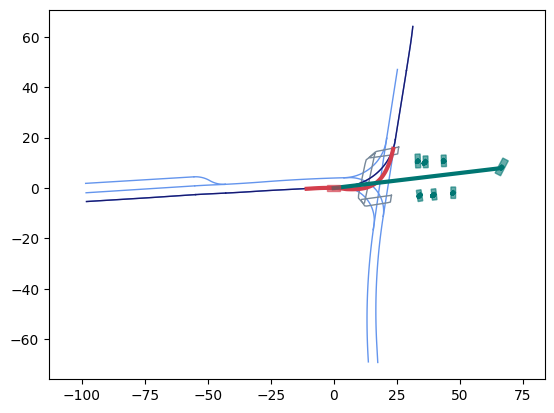

In [37]:
from nuplan.planning.scenario_builder.abstract_scenario import AbstractScenario
from nuplan.common.actor_state.ego_state import EgoState
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters

import matplotlib as mpl

class DataProcessor:
	scenario: AbstractScenario
	anchor_ego_state: EgoState
 
	def __init__(self, scenario):
		# map api
		self.scenario = scenario
		
		# discrete 1 second to several points
		self.discrete_size = 10

		# history observation horizon
		self.past_time_horizon = 2

		# prediction horizon
		self.future_time_horizon = 8

		# number of discrete trajectory points
		self.num_past_poses = self.discrete_size * self.past_time_horizon

		# number of discrete trajectory points in future horizon
		self.num_future_poses = self.discrete_size * self.future_time_horizon

		# deal with top 20 closest agents around the ego vehicle
		self.num_agents = 20

		# [m] query radius scope relative to the current pose.
		self.query_radius = 60

		# [m/s] velocity threshold for determine weather an agent is static.
		# FIXME: Unused
		self.velocity_thresh = 2
  
		# Interpolation method to apply when interpolating to maintain fixed size map elements.
		self.interpolation_method = 'linear'

		# name of map features to be extracted.
		self.map_features = [
			'LANE', 
			'ROUTE_LANES', 
			'CROSSWALK'
		] 

		# maximum number of elements to extract per feature layer.
		self.max_elements = {
			'LANE': 40, 
			'ROUTE_LANES': 10, 
			'CROSSWALK': 5
		}      
		
		# maximum number of points per feature to extract per feature layer.
		self.max_points = {
			'LANE': 50, 
			'ROUTE_LANES': 50, 
			'CROSSWALK': 30
		}

		# initial state of ego vehicle
		self.anchor_ego_state = self.scenario.initial_ego_state
  
		# map related
		self.map_name = self.scenario._map_name
		self.map_api = scenario.map_api

		# debug
		self.debug = True
  
	def process_ego_info(self):
		# get history states
		past_ego_states = self.scenario.get_ego_past_trajectory(
			iteration=0,
			num_samples=self.num_past_poses,
			time_horizon=self.past_time_horizon
		)
  
		sampled_past_ego_states = list(past_ego_states) + [self.anchor_ego_state]

		past_ego_relative_states = convert_absolute_to_relative_poses(
			self.anchor_ego_state.rear_axle,
			[state.rear_axle for state in sampled_past_ego_states]
		)

		# get history timestamps
		past_timestamps = self.scenario.get_past_timestamps(
				iteration=0, 
				num_samples=self.num_past_poses, 
	   			time_horizon=self.past_time_horizon
		)	

		sampled_past_timestamps = list(past_timestamps) + [self.scenario.start_time]
		initial_timestamp = sampled_past_timestamps[0].time_s

		past_timestamp_list = [timestamp.time_s - initial_timestamp for timestamp in sampled_past_timestamps]

		# get future states
		future_ego_states = self.scenario.get_ego_future_trajectory(
			iteration=0, 
		 	num_samples=self.num_future_poses, 
		  	time_horizon=self.future_time_horizon
		)

		future_ego_relative_states = convert_absolute_to_relative_poses(
			self.anchor_ego_state.rear_axle,
			[state.rear_axle for state in future_ego_states]
		)

		# get future timestamps
		future_timestamps = self.scenario.get_future_timestamps(
			iteration=0,
			num_samples=self.num_future_poses,
			time_horizon=self.future_time_horizon
		)

		future_timestamp_list = [timestamp.time_s - initial_timestamp for timestamp in future_timestamps]

		# debug
		if self.debug:
			plot_ego(past_ego_relative_states, future_ego_relative_states)
  
		return past_ego_relative_states, future_ego_relative_states, past_timestamp_list, future_timestamp_list

	def process_agent_info(self):
		# get tracked objects at current time
		present_tracked_objects = self.scenario.initial_tracked_objects.tracked_objects
  
		# get tracked obejcts at previous horizon
		past_tracked_objects = [
			tracked_objects.tracked_objects
			for tracked_objects in self.scenario.get_past_tracked_objects(
				iteration=0, 
				time_horizon=self.past_time_horizon, 
	   			num_samples=self.num_past_poses
			)
		]

		# get observed objects
		sampled_past_observations = past_tracked_objects + [present_tracked_objects]
		
		# pack to tensor
		past_tracked_objects_tensor_list, past_tracked_objects_types = \
			  sampled_tracked_objects_to_tensor_list(sampled_past_observations)

		# get timestamp
		past_time_stamps = list(
			self.scenario.get_past_timestamps(
				iteration=0, num_samples=self.num_past_poses, time_horizon=self.past_time_horizon
			)
		) + [self.scenario.start_time]
		
		# turn timestamp list into tensor
		past_time_stamps_tensor = sampled_past_timestamps_to_tensor(past_time_stamps)

		# get anchor_ego_state in the form of list [x, y, θ]
		anchor_ego_state_list = [0] * Agents.agents_states_dim()
		anchor_ego_state_list[EgoInternalIndex.x()] = self.anchor_ego_state.rear_axle.x
		anchor_ego_state_list[EgoInternalIndex.y()] = self.anchor_ego_state.rear_axle.y
		anchor_ego_state_list[EgoInternalIndex.heading()] = self.anchor_ego_state.rear_axle.heading

		# 1. Filter detections to keep only agents which appear in the last frame
		# 2. Turn the observation into tensor: 
  		#		[x, y, θ, vx, vy, θ', length, width, agent type]
		#    Agent type is one-hot encoded: 
  		# 		[1, 0, 0] vehicle, 
		#		[0, 1, 0] pedestrian, 
	 	#	 	[0, 0, 1] bicycle
		neighbor_agents_past, agent_indices = agent_past_process(
			anchor_ego_state_list, 
			past_time_stamps_tensor, 
			past_tracked_objects_tensor_list, 
			past_tracked_objects_types, 
			self.num_agents
		)

		# get future tracked objects
		future_tracked_objects = [
			tracked_objects.tracked_objects
			for tracked_objects in self.scenario.get_future_tracked_objects(
				iteration=0, 
				time_horizon=self.future_time_horizon, 
				num_samples=self.num_future_poses
			)			
		]

		# get prediction
		sampled_future_observations = [present_tracked_objects] + future_tracked_objects

		# turn list into tensor
		future_tracked_objects_tensor_list, _ = \
			sampled_tracked_objects_to_tensor_list(sampled_future_observations)

		# 1. Filter detections to keep only agents which appear in the first frame
		# 2. Turn the observation into tensor [x, y, θ]
		neighbor_agent_futures = agent_future_process(
	  		self.anchor_ego_state, 
			future_tracked_objects_tensor_list, 
		 	self.num_agents, 
		  	agent_indices
		)

		if self.debug:
			plot_agent(neighbor_agents_past, neighbor_agent_futures, agent_indices)
  
		return neighbor_agents_past, neighbor_agent_futures

	def process_map_info(self):
		# convert state to 2D pose
		ego_coords = Point2D(
	  		self.anchor_ego_state.rear_axle.x, 
			self.anchor_ego_state.rear_axle.y
		)

		# get roadblock id list
		route_roadblock_ids = self.scenario.get_route_roadblock_ids()
		
		# get traffic light data
		traffic_light_data = self.scenario.get_traffic_light_status_at_iteration(0)
		
		# get neighbor vector set and 
		coords, traffic_light_data = get_neighbor_vector_set_map(
			self.map_api,
			self.map_features, 
			ego_coords,
			self.query_radius,
			route_roadblock_ids,
			traffic_light_data
		)

		# get tensorized vector map dictionary
		vector_map = map_process(
	  		self.anchor_ego_state.rear_axle, 
			coords, 
		 	traffic_light_data, 
		  	self.map_features, 
			self.max_elements, 
			self.max_points, 
			self.interpolation_method
		)

		if self.debug:
			plot_vector_map(
	   			vector_map['lanes'], 
		  		vector_map['crosswalks'], 
				vector_map['route_lanes']
			)
		
		# Dict('Type', List[x, y, heading, traffic_light_status(x, x, x, x)])
		return vector_map

COLOR_DICT = {
	'centerline' : '#6495ED',
	'crosswalk'  : '#778899',
	'route_lane' : '#191970',
	'agent'      : '#007672',
	'ego'        : '#d33e4c',
	'others'     : '#d3e8ef',
}

VELOCITY_THRESH = 1

def plot_rectangle(x_center, y_center, heading, length, width, color):
	agent_bottom_right = (
		x_center - length/2, 
		y_center - width/2
	)
	
	rect = plt.Rectangle(
		agent_bottom_right, 
		length, 
		width, 
		linewidth=1, 
		color=color, 
		alpha=0.6, 
		zorder=3,
		transform=mpl.transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData
	)
	plt.gca().add_patch(rect)    

def plot_vector_map(lanes, crosswalks, route_lanes):
	# plot centerline
	for i in range(lanes.shape[0]):
		lane = lanes[i]
		if lane[0][0] != 0:
			plt.plot(
	   			lane[:, 0], 
		  		lane[:, 1], 
				color=COLOR_DICT['centerline'], 
			 	linewidth=1
			) 

 	# plot crosswalk
	for j in range(crosswalks.shape[0]):
		crosswalk = crosswalks[j]
		if crosswalk[0][0] != 0:
			plt.plot(
	   			crosswalk[:, 0], 
		  		crosswalk[:, 1], 
				color=COLOR_DICT['crosswalk'], 
			 	linewidth=1
			) 

 	# plot route_lanes
	for k in range(route_lanes.shape[0]):
		route_lane = route_lanes[k]
		if route_lane[0][0] != 0:
			plt.plot(
	   			route_lane[:, 0], 
		  		route_lane[:, 1], 
				color=COLOR_DICT['route_lane'], 
			 	linewidth=1
			) 

	plt.axis('equal')

def plot_ego(past_coords, future_coords):
	# plot history trajectory
	plt.plot(
		past_coords[:, 0], 
  		past_coords[:, 1], 
		color=COLOR_DICT['ego'], 
	 	linewidth=3)
 
	# plot future trajectory
	plt.plot(
		future_coords[:, 0], 
	 	future_coords[:, 1], 
	  	color=COLOR_DICT['ego'], 
	   	linewidth=3
	)
	
	# plot query point
	vehicle_parameters = get_pacifica_parameters()
	plot_rectangle(
		x_center=past_coords[-1, 0],
		y_center=past_coords[-1, 1],
		heading=past_coords[-1, 2],
		length=vehicle_parameters.front_length + vehicle_parameters.rear_length,
		width=vehicle_parameters.width,
		color=COLOR_DICT['ego']
	)

	plt.axis('equal')

def plot_agent(agents_history, agents_future, agent_index):
	for i in range(len(agent_index)):
		agent = agents_history[i]
  
		if agent[0, 0] == 0:
			continue
		
		vx = agent[:, 3]
		vy = agent[:, 4]
		speeds = np.sqrt(vx**2 + vy**2)
		mean_speed = np.mean(speeds)
		
		agent_type = agent[0, 8:11]
	
		if (agent_type == np.array([1, 0, 0])).all() or mean_speed < VELOCITY_THRESH:
			agent_color = COLOR_DICT['agent']
		else:
			agent_color = COLOR_DICT['others']

		plt.plot(
			agents_history[i, :, 0], 
			agents_history[i, :, 1], 
			color=agent_color, 
			linewidth=3
		)

		plt.plot(
			agents_future[i, :, 0], 
			agents_future[i, :, 1], 
			color=agent_color, 
			linewidth=3
		)
	
		plot_rectangle(
			x_center=agent[-1, 0],
			y_center=agent[-1, 1],
			heading=agent[-1, 2],
			length=agent[-1, 6],
			width=agent[-1, 7],
			color=agent_color
		)
  
	plt.axis('equal')

# pick a scenario
scenario = scenarios[1]

# process data
data_processor = DataProcessor(scenario)
vector_map = data_processor.process_map_info()
ego_past, ego_future, pt, ft = data_processor.process_ego_info()
agents_history, agents_future = data_processor.process_agent_info()

In [43]:
import pandas as pd

def agent_ground_truth_traj_to_increment(origin, agent_future):
	origin_x = origin[0]
	origin_y = origin[1]

	start_x = agent_future[ :-1, 0].reshape(-1, 1)
	start_y = agent_future[ :-1, 1].reshape(-1, 1)
	end_x   = agent_future[1:  , 0].reshape(-1, 1)
	end_y   = agent_future[1:  , 1].reshape(-1, 1)

	increment_start_x = start_x[0, 0] - origin_x
	increment_start_y = start_y[0, 0] - origin_y

	increment_x = end_x - start_x
	increment_y = end_y - start_y

	ground_truth = np.hstack((
		increment_x,
		increment_y
	))

	ground_truth = np.vstack((
		np.array([increment_start_x, increment_start_y]),
		ground_truth
	))
 
	return ground_truth

def encoding_feature(
	agent_past, 
	agent_future, 
	ego_past,
	ego_future,
	vector_map
	):
	# each subgraph has its only ID
	subgraph_ID = 0
	
	# each subgraph ID has a series of node. These nodes are stacked 
	# vertically in a list and there has a start node and end node.  
	trajectory_ID_to_indices = {}
	map_ID_to_indices = {}

	# ground truth for vectornet
	ground_truth = agent_future
	
	# create an empty trajectory subgraph
	# each node is a 1 * 8 tensor 
	# [start_x, start_y, end_x, end_y, x, x, x, subgraph_ID]
	# agent type is one hot encoded
	trajectory_subgraph = np.empty((0, 8))
	
	# create an empty map subgraph
	# each node is a 1 * 8 tensor
	# [start_x, start_y, end_x, end_y, x, x, x, subgraph_ID]
	# lane type is one hot encoded
	map_subgraph = np.empty((0, 8))
	
	# encoding ego features
	subgraph_ID = 0
	ego_subgraph = np.hstack((
		ego_past[ :-1, 0].reshape(-1, 1),   
		ego_past[ :-1, 1].reshape(-1, 1),      
		ego_past[1:  , 0].reshape(-1, 1),
		ego_past[1:  , 1].reshape(-1, 1),  
		np.zeros((len(ego_past) - 1, 1)),
		np.zeros((len(ego_past) - 1, 1)), 
		np.zeros((len(ego_past) - 1, 1)),  
		np.ones ((len(ego_past) - 1, 1)) * subgraph_ID
	))
	
	trajectory_subgraph = np.vstack((
		trajectory_subgraph,
		ego_subgraph
	))
	
	start_ID = 0
	end_ID = len(ego_past) - 2
	trajectory_ID_to_indices[subgraph_ID] = (start_ID, end_ID)
	subgraph_ID += 1
	
	# encoding ego ground truth
	ground_truth = np.empty((0, 2))
	ego_ground_truth = agent_ground_truth_traj_to_increment(
     	ego_past[-1], 
      	ego_future
    )
	
	ground_truth = np.vstack((
		ground_truth,
		ego_ground_truth
	))
 
	# encoding agent features
	for i in range(len(agent_past)):
		agent = agent_past[i]
  
		agent_subgraph = np.hstack((
			agent[ :-1, 0].reshape(-1, 1),    
			agent[ :-1, 1].reshape(-1, 1),     
			agent[1:  , 0].reshape(-1, 1),
			agent[1:  , 1].reshape(-1, 1),  
			np.zeros((len(agent) - 1, 1)),
			np.zeros((len(agent) - 1, 1)), 
			np.zeros((len(agent) - 1, 1)),  
			np.ones ((len(agent) - 1, 1)) * subgraph_ID            
		))
		
		trajectory_subgraph = np.vstack((
			trajectory_subgraph,
			agent_subgraph
		))
		
		start_ID = end_ID + 1
		end_ID += len(agent_subgraph)

		trajectory_ID_to_indices[subgraph_ID] = (start_ID, end_ID)
		subgraph_ID += 1

		# ground truth
		origin = agent[-1]
		future = agent_future[i]

		agent_ground_truth = agent_ground_truth_traj_to_increment(
			origin,
			future
		)

		ground_truth = np.vstack((
			ground_truth,
			agent_ground_truth
		))
  
	# encoding lane features
	start_ID = -1
	end_ID = -1

	# encoding centerline features
	for lane in vector_map['lanes']:
		lane_subgraph = np.hstack((
			lane[ :-1, 0].reshape(-1, 1),  
			lane[ :-1, 1].reshape(-1, 1),       
			lane[1:  , 0].reshape(-1, 1),
			lane[1:  , 1].reshape(-1, 1),  
			np.zeros((len(lane) - 1, 1)),
			np.zeros((len(lane) - 1, 1)), 
			np.zeros((len(lane) - 1, 1)),  
			np.ones ((len(lane) - 1, 1)) * subgraph_ID                  
		))

		map_subgraph = np.vstack((
			map_subgraph,
			lane_subgraph
		))
  
		start_ID = end_ID + 1
		end_ID += len(lane_subgraph)
  
		map_ID_to_indices[subgraph_ID] = (start_ID, end_ID)
		subgraph_ID += 1
  
	# encoding crosswalk features
	for lane in vector_map['crosswalks']:
		lane_subgraph = np.hstack((
			lane[ :-1, 0].reshape(-1, 1),  
			lane[ :-1, 1].reshape(-1, 1),       
			lane[1:  , 0].reshape(-1, 1),
			lane[1:  , 1].reshape(-1, 1),  
			np.zeros((len(lane) - 1, 1)),
			np.zeros((len(lane) - 1, 1)), 
			np.zeros((len(lane) - 1, 1)),  
			np.ones ((len(lane) - 1, 1)) * subgraph_ID                  
		))

		map_subgraph = np.vstack((
			map_subgraph,
			lane_subgraph
		))
  
		start_ID = end_ID + 1
		end_ID += len(lane_subgraph)
  
		map_ID_to_indices[subgraph_ID] = (start_ID, end_ID)
		subgraph_ID += 1

	# encoding route lane features
	for lane in vector_map['route_lanes']:
		lane_subgraph = np.hstack((
			lane[ :-1, 0].reshape(-1, 1),  
			lane[ :-1, 1].reshape(-1, 1),       
			lane[1:  , 0].reshape(-1, 1),
			lane[1:  , 1].reshape(-1, 1),  
			np.zeros((len(lane) - 1, 1)),
			np.zeros((len(lane) - 1, 1)), 
			np.zeros((len(lane) - 1, 1)),  
			np.ones ((len(lane) - 1, 1)) * subgraph_ID                  
		))
  
		map_subgraph = np.vstack((
			map_subgraph,
			lane_subgraph
		))
  
		start_ID = end_ID + 1
		end_ID += len(lane_subgraph)
  
		map_ID_to_indices[subgraph_ID] = (start_ID, end_ID)
		subgraph_ID += 1

	# data frame
	feature_data = [[
		np.vstack((trajectory_subgraph, map_subgraph)),
		ground_truth,
		trajectory_ID_to_indices,
		map_ID_to_indices,
		trajectory_subgraph.shape[0],
		map_subgraph.shape[0]
	]]
	
	return pd.DataFrame(
		feature_data,
		columns=[
      		"POLYLINE_FEATURES", 
           	"GROUND_TRUTH",
            "TRAJ_ID_TO_INDICES", 
            "LANE_ID_TO_INDICES", 
            "TARJ_SIZE", 
            "LANE_SIZE"
        ]
	)
	
features_df = encoding_feature(
    agents_history, 
    agents_future, 
    ego_past, 
    ego_future, 
    vector_map
)

def save_features(features_df, file_name, dir):
    feature_file_name = f"features_{file_name}.pkl"
    features_df.to_pickle(
		os.path.join(dir, feature_file_name)
	)

,POLYLINE_FEATURES,GROUND_TRUTH,TRAJ_ID_TO_INDICES,LANE_ID_TO_INDICES,TARJ_SIZE,LANE_SIZE
0,"[[-10.712964057922363, -0.2953440845012665, -1...","[[0.3958604037761688, -0.011644862592220306], ...","{0: (0, 19), 1: (20, 39), 2: (40, 59), 3: (60,...","{21: (0, 48), 22: (49, 97), 23: (98, 146), 24:...",420,2595


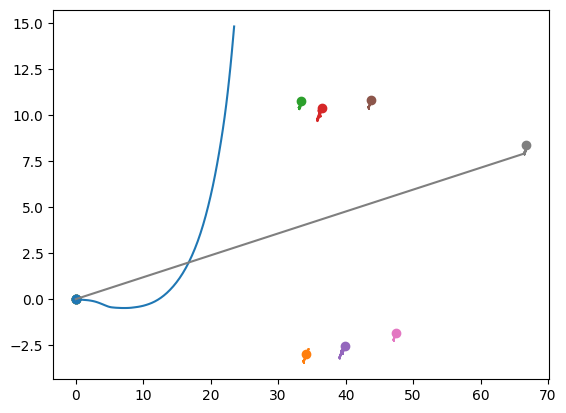